In [846]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [847]:
#### Preprocecing ###

In [848]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [849]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [850]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [851]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]

In [852]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]

In [853]:
removed = recovered + death

In [854]:
### Data Preparation ###

In [855]:
S = confirmed.values
R = removed.values
L=5

In [789]:
data = {'T': S.shape[0], 'N': S.shape[1], 'L': L, 'S': S, 'R': R}

In [790]:
### Model ###

In [791]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6697c03e940e8c41baf7bf7f8f621636 NOW.


In [792]:
# Train the model and generate samples
fit = sm.sampling(data=data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [793]:
### Simulation and Visualization functions ###

In [841]:
T = S.shape[0]
N = S.shape[1]
epoch = pd.to_datetime('2020-01-22')

In [842]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    cumulative_list = [confirmed.loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    infected_list = [(confirmed - removed).loc[d].values for d in 
                        pd.date_range(start - pd.Timedelta(days=L), periods=L, freq='D')]
    for d in range(horizen):
        I = infected_list[-L] @ c * (1 - cumulative_list[-L] / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.clip(I, 0, cumulative - recovered)
        recovered = recovered + a * (cumulative_list[-1] - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.clip(recovered, 0, cumulative)
        infected_list.append(cumulative - recovered)
        cumulative_list.append(cumulative)
        
    infected = pd.DataFrame(infected_list[L:], 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected

In [856]:
def draw_infected(fit, start, horizen, country):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(5000):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame(index=pd.date_range(epoch - pd.Timedelta(days=L), 
                                             start + pd.Timedelta(days=horizen), freq='D'))
    real = (confirmed - removed)[country]
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2)

In [857]:
### Validation ###

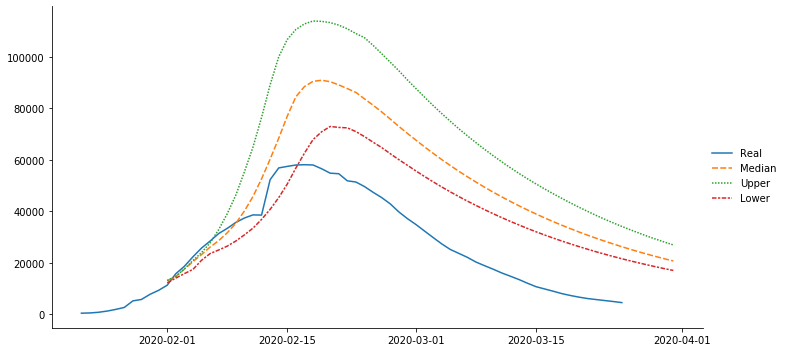

In [858]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

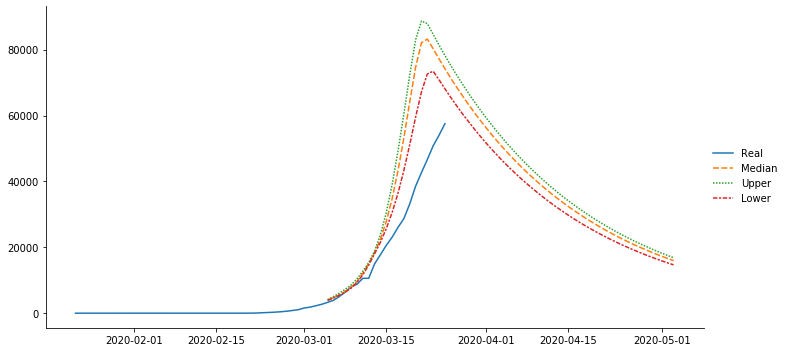

In [859]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

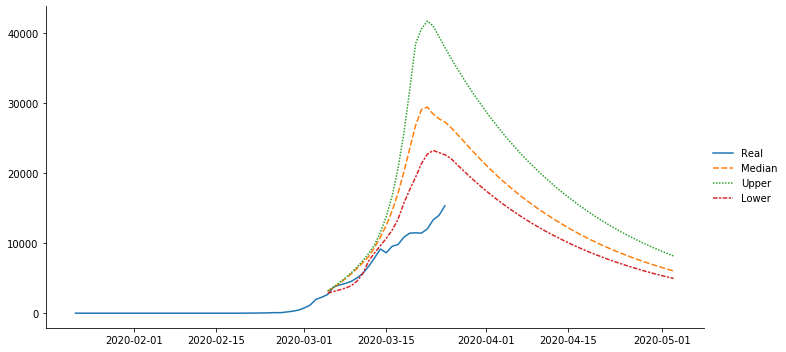

In [860]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

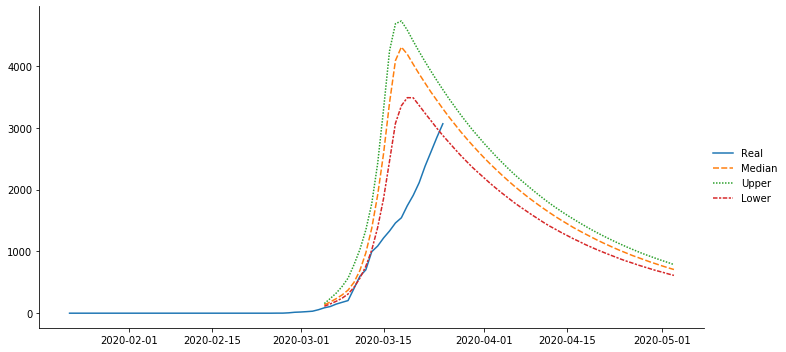

In [861]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

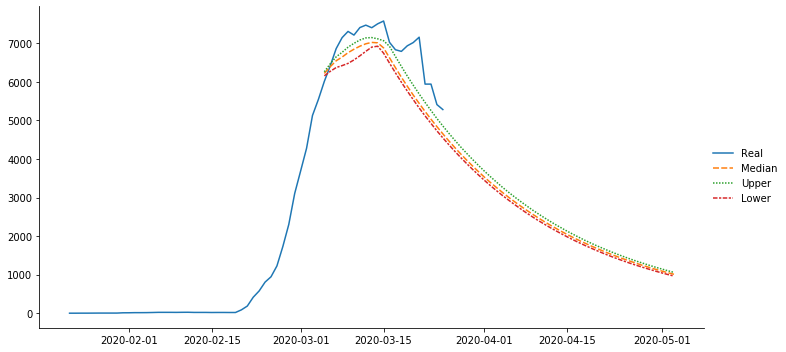

In [862]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

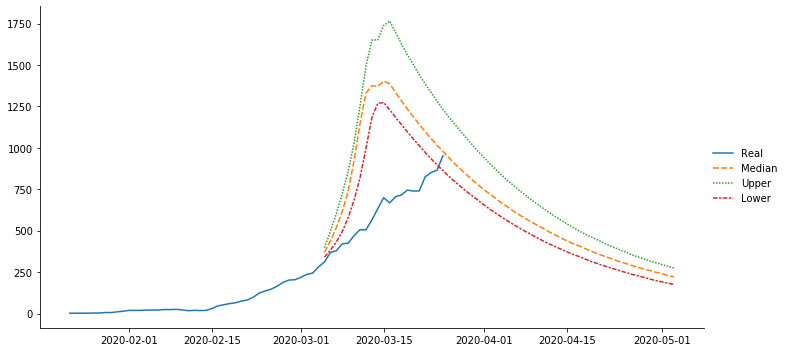

In [863]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

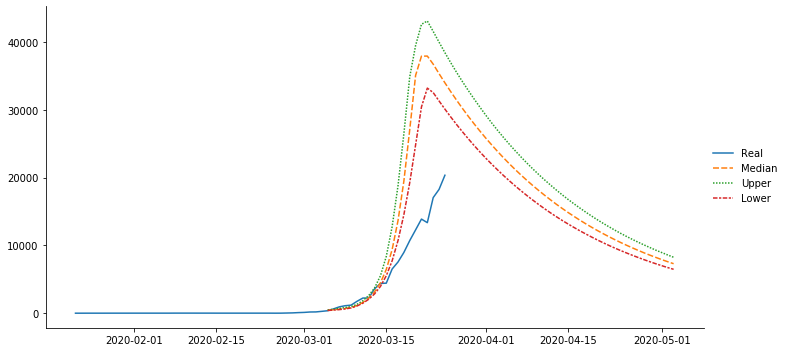

In [864]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

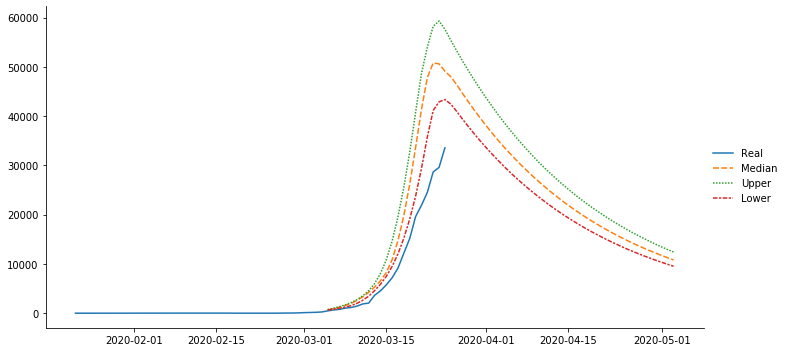

In [865]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

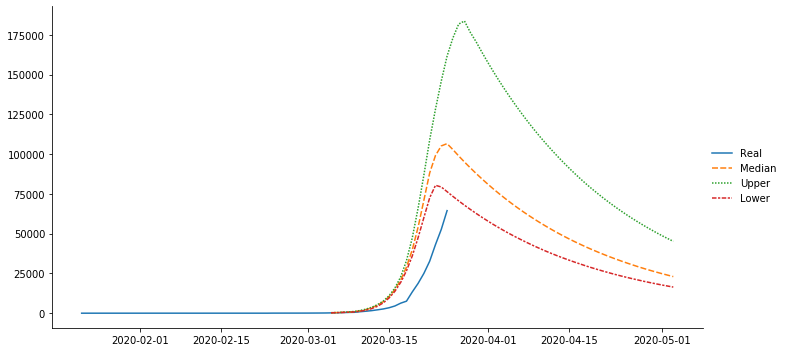

In [866]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [867]:
### Prediction ###

In [868]:
recent = confirmed.index[-1]


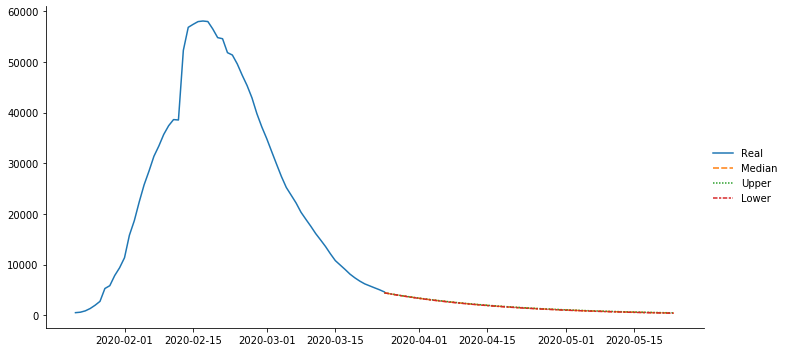

In [869]:
draw_infected(fit, recent, 60, 'China')

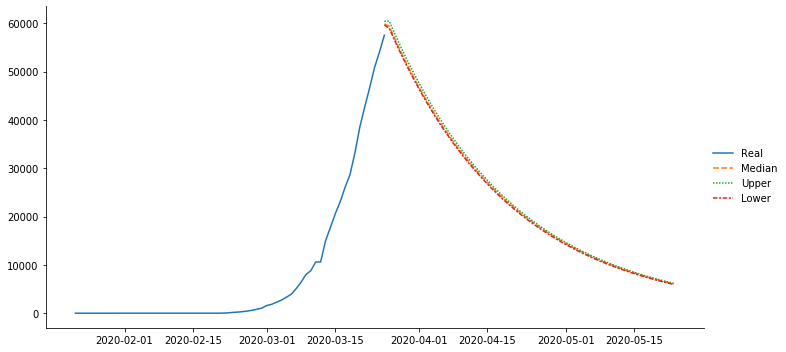

In [870]:
draw_infected(fit, recent, 60, 'Italy')

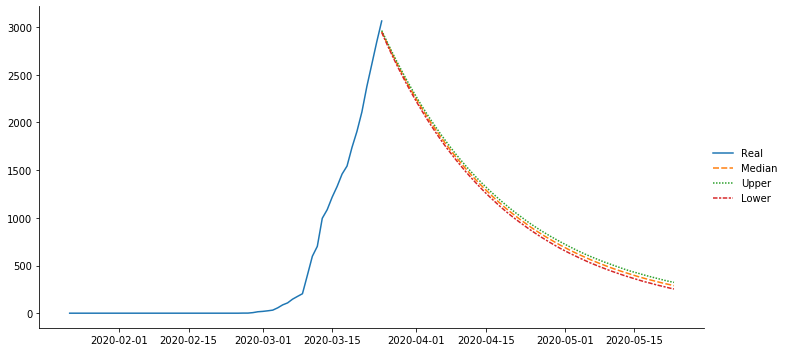

In [871]:
draw_infected(fit, recent, 60, 'Norway')

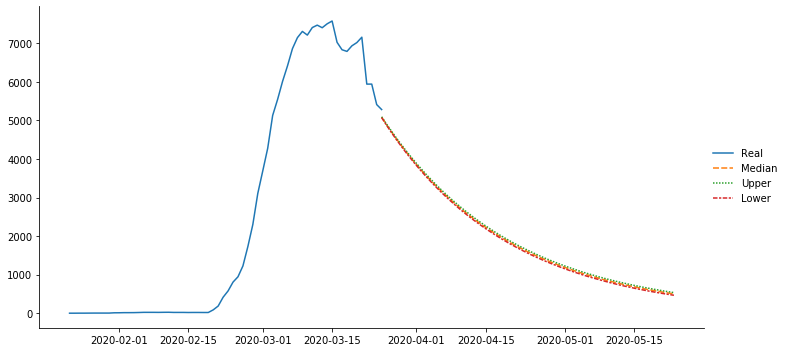

In [872]:
draw_infected(fit, recent, 60, 'Korea, South')

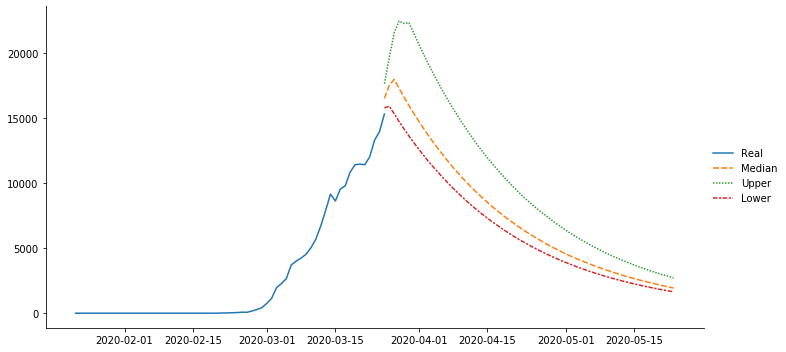

In [873]:
draw_infected(fit, recent, 60, 'Iran')

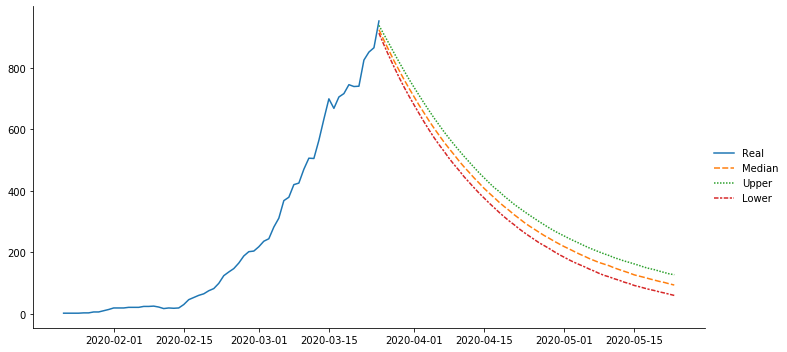

In [874]:
draw_infected(fit, recent, 60, 'Japan')

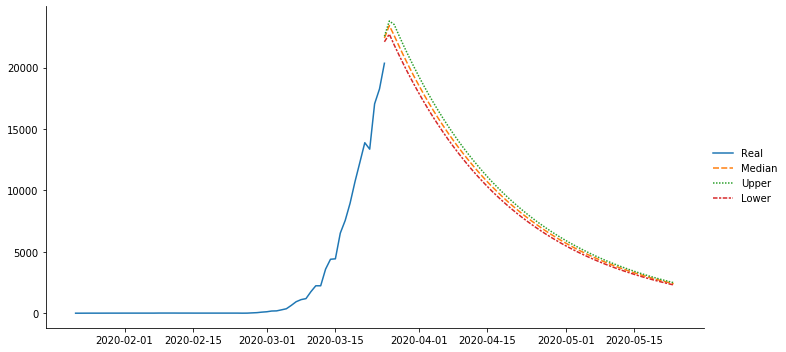

In [875]:
draw_infected(fit, recent, 60, 'France')

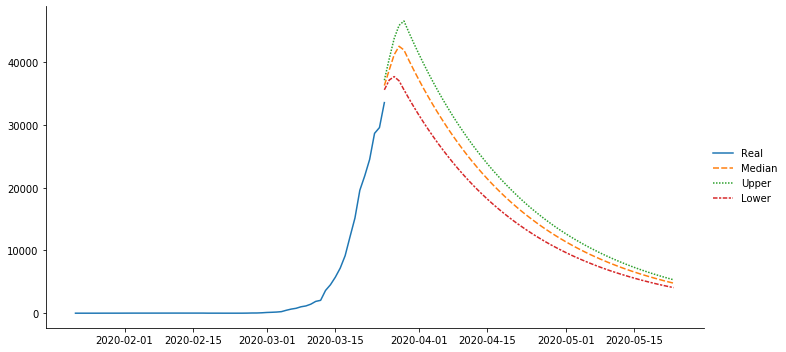

In [876]:
draw_infected(fit, recent, 60, 'Germany')

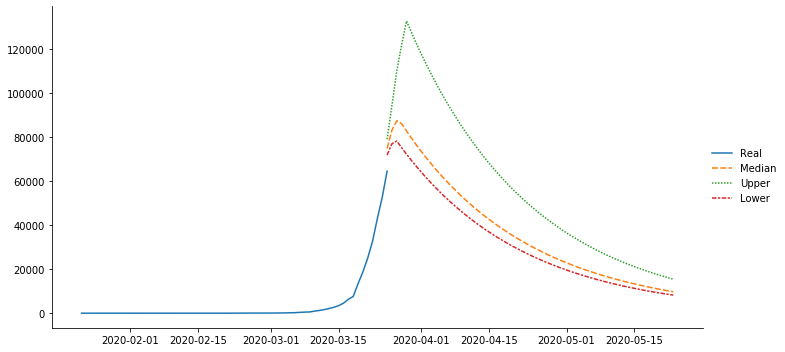

In [877]:
draw_infected(fit, recent, 60, 'US')

In [878]:
def draw_infected_world(fit, start, horizen):
    a_s = fit['a']
    p_s = fit['p']
    c_s = fit['c']
    sigma_S_s = fit['sigma_S']
    sigma_R_s = fit['sigma_R']
    n = a_s.shape[0]
    data = pd.DataFrame()
    for i in range(5000):
        a = a_s[np.random.randint(n)]
        p = p_s[np.random.randint(n)]
        c = c_s[np.random.randint(n)]
        sigma_S = sigma_S_s[np.random.randint(n)]
        sigma_R = sigma_R_s[np.random.randint(n)]
        infected = simulate(a, p, c, sigma_S, sigma_R, start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);
    print("Upper:{}, Median:{}, Lower:{}".format(upper.sum(), median.sum(), lower.sum()))

Upper:19873038.521135543, Median:12049430.447122326, Lower:11428577.709007042


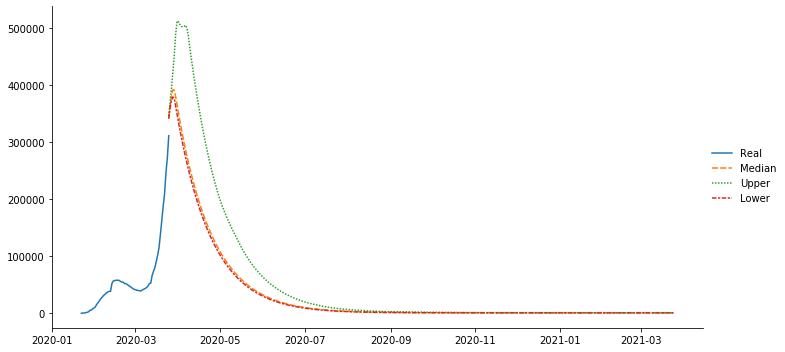

In [879]:
draw_infected_world(fit, recent, 365)

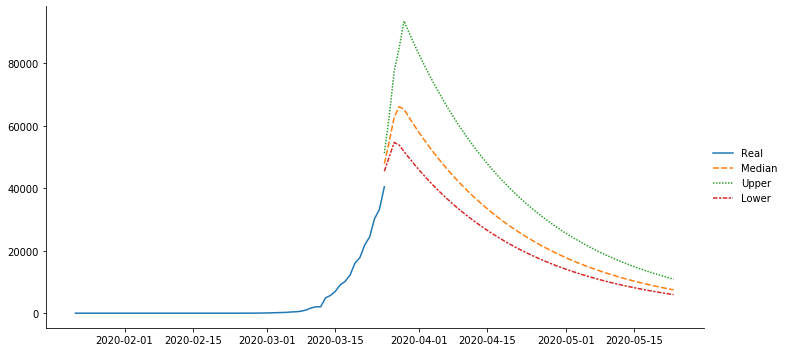

In [880]:
draw_infected(fit, recent, 60, 'Spain')

In [881]:
confirmed.columns

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China',
       'Czechia', 'Denmark', 'Ecuador', 'France', 'Germany', 'Iran', 'Ireland',
       'Israel', 'Italy', 'Japan', 'Korea, South', 'Luxembourg', 'Malaysia',
       'Netherlands', 'Norway', 'Pakistan', 'Poland', 'Portugal', 'Spain',
       'Sweden', 'Switzerland', 'Turkey', 'US', 'United Kingdom'],
      dtype='object', name='Country/Region')

In [882]:
pystan.check_hmc_diagnostics(fit)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

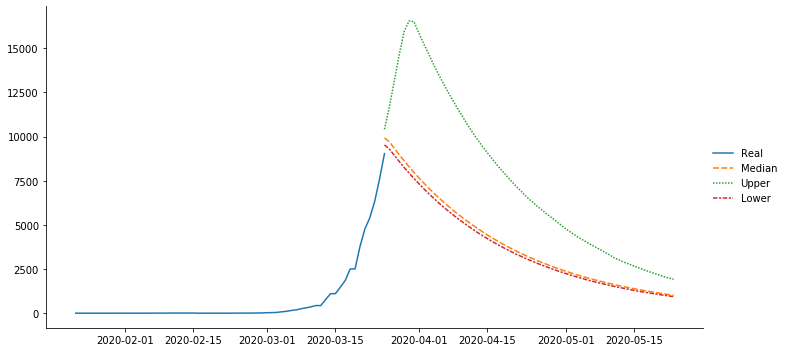

In [883]:
draw_infected(fit, recent, 60, 'United Kingdom')

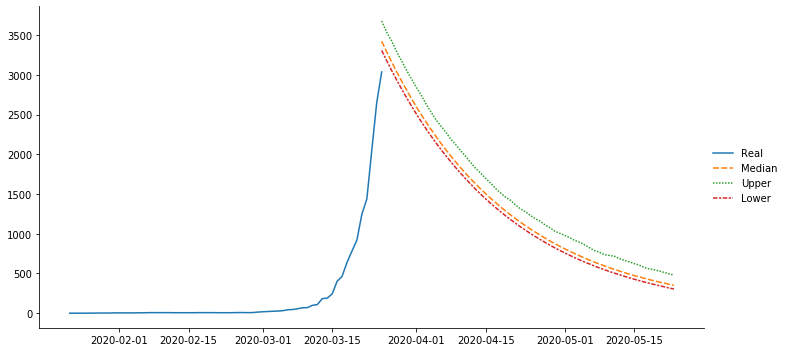

In [884]:
draw_infected(fit, recent, 60, 'Canada')

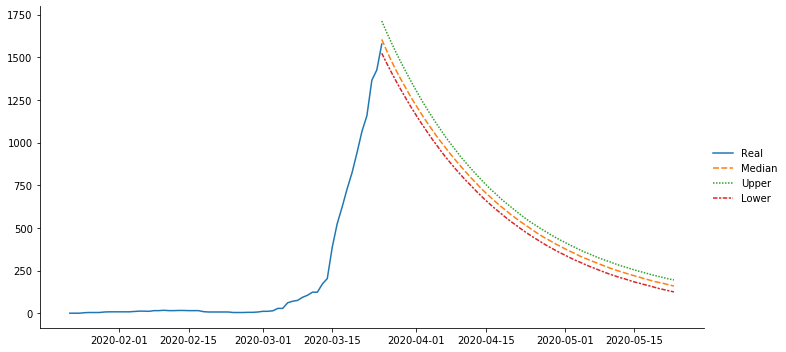

In [885]:
draw_infected(fit, recent, 60, 'Malaysia')

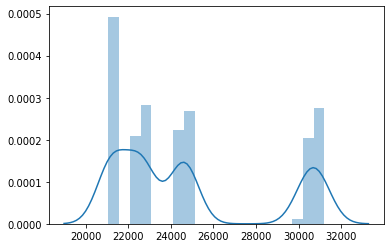

In [886]:
sns.distplot(fit['p'][:,12])

In [887]:
fit['c'].mean(axis=0)[5,5]

0.052874446103773044

In [888]:
confirmed = pd.DataFrame(np.zeros([6, len(confirmed.columns)]), 
                        index=pd.date_range(pd.to_datetime('2020-01-01'), periods=6, freq='D'), 
                       columns=confirmed.columns)
confirmed['China'] = pd.Series([1, 1, 1, 1, 1, 1], 
                             index=pd.date_range(pd.to_datetime('2020-01-01'), periods=6, freq='D'))

In [889]:
removed = pd.DataFrame(np.zeros([6, len(confirmed.columns)]), 
                        index=pd.date_range(pd.to_datetime('2020-01-01'), periods=6, freq='D'), 
                       columns=confirmed.columns)

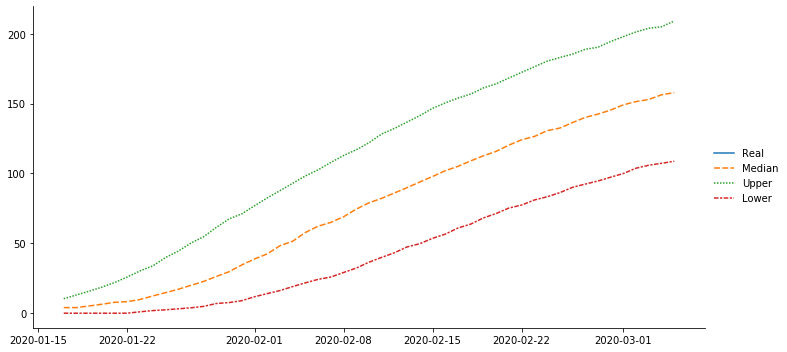

In [890]:
draw_infected(fit, pd.to_datetime('2020-01-06'), 60, 'China')

In [891]:
c = fit['c'][0]

In [892]:
s = confirmed.iloc[1].values

In [893]:
(s @ c).argmax()

6

In [894]:
s

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [895]:
s = np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [896]:
(s @ c)[5]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 25)

In [ ]:
fit['a'][5]

In [ ]:
c[:, 5]

In [ ]:
confirmed.index